In [8]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import imageio

# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.fc(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.qnetwork = QNetwork(state_size, action_size)
        self.target_qnetwork = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=1e-3)
        self.memory = ReplayBuffer(10000)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_every = 10
        self.t_step = 0
        self.losses = []

    def act(self, state, eps=0.0):
        if random.random() > eps:
            with torch.no_grad():
                return torch.argmax(self.qnetwork(torch.tensor(state, dtype=torch.float32))).item()
        else:
            return random.choice(range(4))

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))
        self.t_step += 1
        if self.t_step % self.update_every == 0 and len(self.memory) >= self.batch_size:
            self.learn()

    def learn(self):
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to NumPy arrays then to float32 tensors
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        Q_expected = self.qnetwork(states).gather(1, actions)
        Q_targets = rewards + self.gamma * self.target_qnetwork(next_states).max(1)[0].unsqueeze(1) * (1 - dones)
        loss = nn.MSELoss()(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

        self.soft_update(0.005)


    def soft_update(self, tau):
        for target_param, param in zip(self.target_qnetwork.parameters(), self.qnetwork.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


Episode 0, Total Reward: 1.2830727482810573
Episode 50, Total Reward: -145.56570894184955
Episode 100, Total Reward: -188.20112829078442
Episode 150, Total Reward: -73.21370338010048
Episode 200, Total Reward: -269.97857756541737
Episode 250, Total Reward: -43.982034771721175
Episode 300, Total Reward: 86.67058809274735
Episode 350, Total Reward: 7.500873939687803
Episode 400, Total Reward: 203.83270744983417
Episode 450, Total Reward: 208.52455821674747
Episode 500, Total Reward: -80.76039122311906
Episode 550, Total Reward: 237.5708153277272
Episode 600, Total Reward: 222.99585944089213
Episode 650, Total Reward: 240.84057387359206
Episode 700, Total Reward: 255.94283839336606
Episode 750, Total Reward: 230.6547154407152
Episode 800, Total Reward: 252.51522218579558
Episode 850, Total Reward: 268.5055026325118
Episode 900, Total Reward: 262.15266676509077
Episode 950, Total Reward: 285.38012329969916
Episode 999, Total Reward: 27.181464882629086


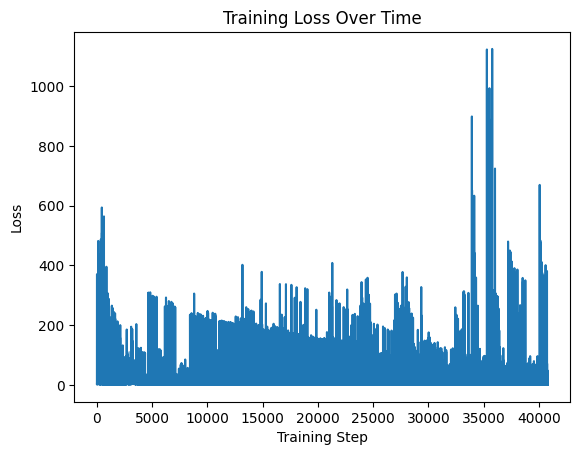

In [9]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
agent = DQNAgent(state_size=8, action_size=4)

n_episodes = 1000
eps = 1.0
eps_decay = 0.995
eps_min = 0.01
rewards = []

frames = []

for i in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state, eps)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    rewards.append(total_reward)
    eps = max(eps * eps_decay, eps_min)

    if i % 50 == 0 or i == n_episodes - 1:
        print(f"Episode {i}, Total Reward: {total_reward}")

# Save learning progress
plt.plot(rewards)
plt.title("Episode Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.savefig("rewards.png")
plt.clf()

plt.plot(agent.losses)
plt.title("Training Loss Over Time")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.savefig("loss.png")


In [27]:

def save_gif_simple(agent, path="agent.gif"):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    state, _ = env.reset()
    frames = []

    done = False
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state, eps=0)
        next_state, _, terminated, truncated, _ = env.step(action)
        state = next_state
        done = terminated or truncated

    imageio.mimsave(path, frames, fps=30)

save_gif_simple(agent)

